## Bernstein-Vazirani Demo

### Build and Compile the Circuit

<img src='./bv_circuit.png' width=60%>

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
q = QuantumRegister(4, 'q')
tmp = QuantumRegister(1, 'tmp')
res = ClassicalRegister(4, 'res')

In [2]:
# Build oracle. The secret number is represented by integer s.
s = 9 # 1001
oracle = QuantumCircuit(q, tmp, res)
for i in range(len(q)):
    if (s & (1 << i)):
        oracle.cx(q[i], tmp[0])

In [3]:
# Embed oracle in the larger BV circuit
bv = QuantumCircuit(q, tmp, res)
bv.x(tmp[0])
bv.barrier()
bv.h(q)
bv.h(tmp)
bv.barrier()
bv += oracle
bv.barrier()
bv.h(q)
bv.h(tmp)
bv.barrier()
bv.measure(q, res)

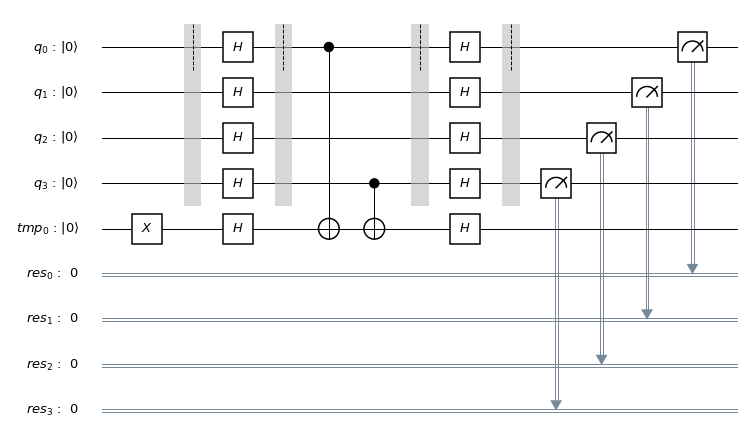

In [4]:
%matplotlib inline
from qiskit.tools.visualization import circuit_drawer
circuit_drawer(bv, output='mpl', scale=0.7)

### Execute on a Simulator

In [5]:
# Access local simulators from Qiskit Aer
from qiskit import Aer, execute
Aer.backends()

[<QasmSimulator('qasm_simulator') from Aer()>,
 <QasmSimulatorPy('qasm_simulator_py') from Aer()>,
 <StatevectorSimulator('statevector_simulator') from Aer()>,
 <StatevectorSimulatorPy('statevector_simulator_py') from Aer()>,
 <UnitarySimulator('unitary_simulator') from Aer()>,
 <CliffordSimulator('clifford_simulator') from Aer()>]

In [6]:
simulator = Aer.get_backend('qasm_simulator')
sim_result = execute(bv, simulator).result()

In [7]:
from qiskit.tools.visualization import plot_histogram
sim_counts = sim_result.get_counts()
sim_counts

{'1001': 1024}

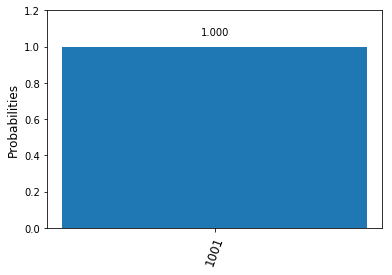

In [8]:
plot_histogram(sim_counts)

The Bernstein-Vazirani circuit finds the secret bitstring 100% of the time, with just 1 Oracle query.

### Execute on a Quantum Computer

In [9]:
# authenticate to use IBMQ remote backends 
from qiskit import IBMQ
IBMQ.load_accounts()
IBMQ.backends()

[<IBMQBackend('ibmqx4') from IBMQ()>,
 <IBMQBackend('ibmqx5') from IBMQ()>,
 <IBMQBackend('ibmqx2') from IBMQ()>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ()>,
 <IBMQBackend('ibmq_qasm_simulator') from IBMQ()>]

In [10]:
# let's choose a 5-qubit device and execute
device = IBMQ.get_backend('ibmq_5_tenerife')

In [11]:
# import jupyter magic tools to ease tracking of submitted job's progress
from qiskit.wrapper.jupyter import *

In [ ]:
%%qiskit_job_status

# qiskit jobs are submitted asynchronously. You can monitor a submitted job's status
job = execute(bv, device, shots=1024)

A Jupyter Widget

In [ ]:
# NOTICE! Executing this cell will block until result is available
device_result = job.result()
device_counts = device_result.get_counts()
plot_histogram(device_counts)

Got a 500 code response to https://quantumexperience.ng.bluemix.net/api/Jobs/5bd0959b48034200622064f4/status?access_token=bisuutI5ZFshFvSf6v62ZZqtvG8AZJkLq5Ijw6CsUr0DvAyCNZ3PPDaOspBFa4EK: 500 Error: Failed to establish a backside connection
Got a 502 code response to https://quantumexperience.ng.bluemix.net/api/Jobs/5bd0959b48034200622064f4/status?access_token=bisuutI5ZFshFvSf6v62ZZqtvG8AZJkLq5Ijw6CsUr0DvAyCNZ3PPDaOspBFa4EK: 502 Bad Gateway: Registered endpoint failed to handle the request.

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/urllib3/connection.py", line 141, in _new_conn
    (self.host, self.port), self.timeout, **extra_kw)
  File "/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 83, in create_connection
    raise err
  File "/anaconda3/lib/python3.6/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
TimeoutError: [Errno 60] Operation timed ou

Real devices are noisy. We repeat the experiment for 1000 shots to find the correct answer among the noise.

### [Optional] Effect of Compilation on Solution

Our circuit does not conform to the topology of our device as-is. Therefore, the compiler must rewrite the circuit to satisfy the device's connectivity constraints:

<img src='./ibmqx4-connections_1pt2pt0.png' width=20%>

As you will see here, the optimality of the compiler can have a large impact on result fidelity.

In [ ]:
# what does Qiskit's compiled circuit look like?
from qiskit import qobj_to_circuits
qobj_0 = compile(bv, device)
compiled_circ_0 = qobj_to_circuits(qobj_0)[0]
circuit_drawer(compiled_circ_0, scale=0.3)

In [ ]:
# force Qiskit to compile differently
initial_layout = {('q', 0):('q', 3), ('q', 1):('q', 2), ('q', 2):('q', 4), ('q', 3):('q', 0), ('tmp', 0):('q', 1)}
qobj_1 = compile(bv_circ, device, initial_layout=initial_layout)
compiled_circ_1 = qobj_to_circuits(qobj_1)[0]
circuit_drawer(compiled_circ_1, scale=.3)

In [ ]:
%%qiskit_job_status

# run the latter circuit. 
# compare with the original run to see effect of compilation on result fidelity.
job = execute(compiled_circ_1, device)

In [ ]:
device_result = job.result()
device_counts = device_result.get_counts()
plot_histogram(device_counts)